In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [39]:
df = pd.read_csv("/projects/ly_vu_direct_rna/MetaCompore/results/xpore/xpore_eventalign/MYC/cnot3_test_0_data_MYC.tsv",sep="\t")

In [40]:
df.columns = ["contig","position","reference_kmer","read_index","strand","event_index","event_level_mean","event_stdv","event_length","model_kmer","model_mean","model_stdv","standardized_level","start_idx","end_idx"]

In [41]:
df.head()

,contig,position,reference_kmer,read_index,strand,event_index,event_level_mean,event_stdv,event_length,model_kmer,model_mean,model_stdv,standardized_level,start_idx,end_idx
0,ENST00000377970.6,0,CTGCT,664445,t,10,98.27,1.969,0.00233,CTGCT,96.87,3.13,0.38,104237,104244
1,ENST00000377970.6,1,TGCTC,664445,t,11,109.60,5.097,0.00467,TGCTC,108.76,3.55,0.20,104223,104237
2,ENST00000377970.6,2,GCTCG,664445,t,12,79.01,1.978,0.00333,GCTCG,78.06,2.85,0.28,104213,104223
3,ENST00000377970.6,2,GCTCG,664445,t,13,80.79,2.180,0.00433,GCTCG,78.06,2.85,0.81,104200,104213
4,ENST00000377970.6,2,GCTCG,664445,t,14,77.04,1.740,0.00867,GCTCG,78.06,2.85,-0.30,104174,104200


In [42]:
print(df.describe())

            position     read_index    event_index  event_level_mean  \
count  691579.000000  691579.000000  691579.000000     691579.000000   
mean     1121.928955  664513.623207    2701.849442         95.344854   
std       672.700077      39.851666    1611.656332         17.517032   
min         0.000000  664445.000000       1.000000         48.320000   
25%       531.000000  664479.000000    1355.000000         80.610000   
50%      1103.000000  664513.000000    2650.000000         93.030000   
75%      1696.000000  664548.000000    3941.000000        109.210000   
max      2346.000000  664587.000000    9407.000000        151.400000   

          event_stdv   event_length     model_mean     model_stdv  \
count  691579.000000  691579.000000  691579.000000  691579.000000   
mean        3.654939       0.007056      93.756895       3.620649   
std         2.749940       0.005833      20.299477       1.596048   
min         0.000000       0.001670       0.000000       0.000000   
25%   

In [43]:
df.loc[ df['event_level_mean'] <= 80.100000, 'event_level_mean'] = 0
df.loc[(df['event_level_mean'] > 80.100000) & (df['event_level_mean'] <= 92.590000), 'event_level_mean'] = 1
df.loc[(df['event_level_mean'] > 92.590000) & (df['event_level_mean'] <= 109.320000), 'event_level_mean']   = 2
df.loc[ df['event_level_mean'] > 109.320000, 'event_level_mean'] = 3
df['event_level_mean'] = df['event_level_mean'].astype(int)

In [44]:
y = df.event_level_mean.values
x_data = df.drop(['event_level_mean',"contig","read_index","strand","event_index","event_stdv","model_kmer","model_stdv","standardized_level","start_idx","end_idx"], axis = 1)

In [45]:
# Normalize
x_data['reference_kmer'] = pd.factorize(x_data['reference_kmer'])[0]
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

/projects/ly_vu_direct_rna/pipeline-polya-diff/.snakemake/conda/b03f8a95a14cdc0ca0aa7496df1e519e/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/projects/ly_vu_direct_rna/pipeline-polya-diff/.snakemake/conda/b03f8a95a14cdc0ca0aa7496df1e519e/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/projects/ly_vu_direct_rna/pipeline-polya-diff/.snakemake/conda/b03f8a95a14cdc0ca0aa7496df1e519e/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(ax

In [46]:
# 80% of our data will be train data and 20% of it will be test data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [47]:
#transpose matrices
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

In [48]:
# weight = 0.01 and bias = 0.0
#initialize
def initialize(dimension):
    
    weight = np.full((dimension,1),0.01)
    bias = 0.0
    return weight,bias

In [49]:
def sigmoid(z):
    
    y_head = 1/(1+ np.exp(-z))
    return y_head

In [50]:
def forwardBackward(weight,bias,x_train,y_train):
    # Forward
    
    y_head = sigmoid(np.dot(weight.T,x_train) + bias)
    loss = -(y_train*np.log(y_head) + (1-y_train)*np.log(1-y_head))
    cost = np.sum(loss) / x_train.shape[1]
    
    # Backward
    derivative_weight = np.dot(x_train,((y_head-y_train).T))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"Derivative Weight" : derivative_weight, "Derivative Bias" : derivative_bias}
    
    return cost,gradients

In [51]:
def update(weight,bias,x_train,y_train,learningRate,iteration) :
    costList = []
    index = []
    
    #for each iteration, update weight and bias values
    for i in range(iteration):
        cost,gradients = forwardBackward(weight,bias,x_train,y_train)
        weight = weight - learningRate * gradients["Derivative Weight"]
        bias = bias - learningRate * gradients["Derivative Bias"]
        
        costList.append(cost)
        index.append(i)

    parameters = {"weight": weight,"bias": bias}
    
    print("iteration:",iteration)
    print("cost:",cost)

    plt.plot(index,costList)
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()

    return parameters, gradients

In [52]:
def predict(weight,bias,x_test):
    z = np.dot(weight.T,x_test) + bias
    y_head = sigmoid(z)

    y_prediction = np.zeros((1,x_test.shape[1]))
    
    for i in range(y_head.shape[1]):
        if y_head[0,i] <= 0.5:
            y_prediction[0,i] = 0
        else:
            y_prediction[0,i] = 1
    return y_prediction

In [53]:
def logistic_regression(x_train,y_train,x_test,y_test,learningRate,iteration):
    dimension = x_train.shape[0]
    weight,bias = initialize(dimension)
    
    parameters, gradients = update(weight,bias,x_train,y_train,learningRate,iteration)

    y_prediction = predict(parameters["weight"],parameters["bias"],x_test)
    
    print("Manuel Test Accuracy: {:.2f}%".format((100 - np.mean(np.abs(y_prediction - y_test))*100)))

In [54]:
print(x.dtypes)


position          float64
reference_kmer    float64
event_length      float64
model_mean        float64
dtype: object


/tmp/ipykernel_128616/833209203.py:5: RuntimeWarning: divide by zero encountered in log
  loss = -(y_train*np.log(y_head) + (1-y_train)*np.log(1-y_head))
/tmp/ipykernel_128616/833209203.py:5: RuntimeWarning: invalid value encountered in multiply
  loss = -(y_train*np.log(y_head) + (1-y_train)*np.log(1-y_head))
/projects/ly_vu_direct_rna/pipeline-polya-diff/.snakemake/conda/b03f8a95a14cdc0ca0aa7496df1e519e/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


iteration: 1000
cost: nan


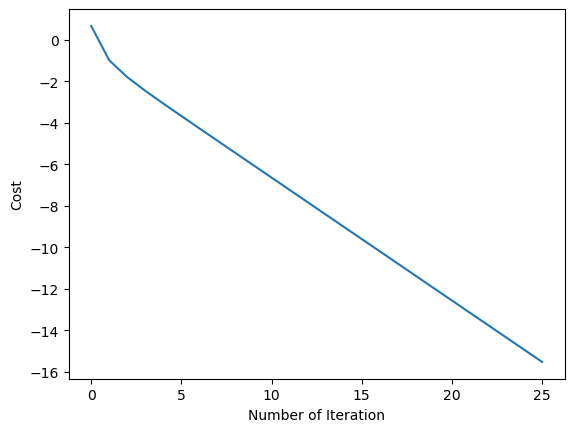

Manuel Test Accuracy: 0.58%


In [55]:
logistic_regression(x_train,y_train,x_test,y_test,1,1000)

In [56]:
accuracies = {}

lr = LogisticRegression()
lr.fit(x_train.T,y_train.T)
acc = lr.score(x_test.T,y_test.T)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 75.69%


/projects/ly_vu_direct_rna/pipeline-polya-diff/.snakemake/conda/b03f8a95a14cdc0ca0aa7496df1e519e/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(x_train.T, y_train.T)

acc = rf.score(x_test.T,y_test.T)*100
accuracies['Random Forest'] = acc
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))

Random Forest Algorithm Accuracy Score : 80.77%


In [65]:
y_pred = rf.predict(x_test.T)
print(y_pred)

[3 0 1 ... 1 1 0]


In [58]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(x_train.T, y_train.T)
prediction = knn.predict(x_test.T)

print("{} NN Score: {:.2f}%".format(2, knn.score(x_test.T, y_test.T)*100))

2 NN Score: 75.86%


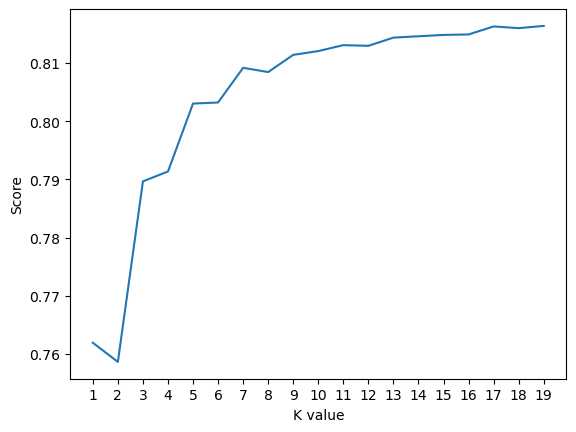

Maximum KNN Score is 81.64%


In [59]:
# try ro find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(x_train.T, y_train.T)
    scoreList.append(knn2.score(x_test.T, y_test.T))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.2f}%".format(acc))

In [60]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(x_train.T, y_train.T)

acc = svm.score(x_test.T,y_test.T)*100
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc))

Test Accuracy of SVM Algorithm: 79.27%


In [61]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train.T, y_train.T)

acc = nb.score(x_test.T,y_test.T)*100
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.2f}%".format(acc))

Accuracy of Naive Bayes: 73.21%


In [62]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train.T, y_train.T)

acc = dtc.score(x_test.T, y_test.T)*100
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.2f}%".format(acc))

Decision Tree Test Accuracy 80.33%


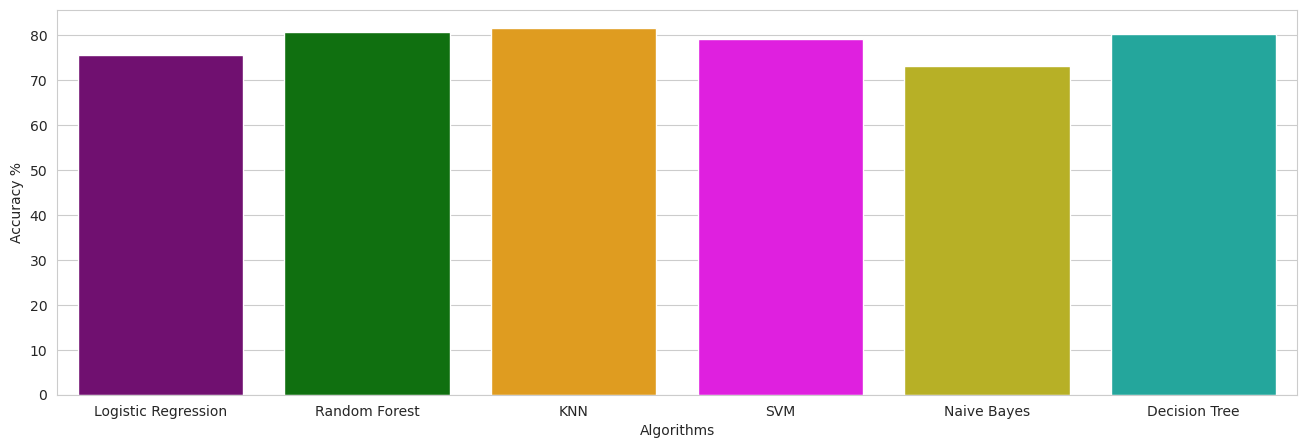

In [63]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()